# 04: Pick Counterfactuals

## Constants

Define setting-specific constants, which are used for propensity score estimation here.
In principle, one could use different values here for propensity score estimation than for later estimation, but this is not advised because it may result in poor balance.

* `d_bin_size`: How wide should each distance bin be (in miles)?
* `d_bin_max`: What is the largest distance at which treatments matter (in miles)?

In [1]:
d_bin_size <- 0.025
d_bin_max <- 0.25

## Required R packages

* `dplyr` for data management
* `ggplot2` for plotting figures to inspect the counterfactuals
* `Rcpp` to call C++ code for fast nearest neighbor matching
* `readr` to read in .csv files with neural network prediction
* `reticulate` to call Python code for fast calculation of distances between many points
* `sf` to transform planar coordinates into latitude and longitude
* `tidyr` to pivot tables


In [2]:
library(dplyr)
library(ggplot2)
library(Rcpp)
library(readr)
library(reticulate)
library(sf)
library(tidyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Linking to GEOS 3.9.3, GDAL 3.5.2, PROJ 8.2.1; sf_use_s2() is TRUE



## Source C++ and Python helper functions

In [3]:
sourceCpp("match_nearest.cpp")
source_python("dist_between_vectors.py")

## Pre-process neural net output

Load the neural network activation

In [4]:
dat_pred_loc_in <- read_csv(unz("neural-net/predicted_activation-2021-11-23--13-37.zip",
                                "predicted_activation-2021-11-23--13-37.csv"),
                            col_types = "iliid", lazy=FALSE)

and find their coordinates by matching each relative location to its center

In [5]:
# load geo locations of center points
dat_S <- readRDS("data/dat_S.rds")
dat_S_candidate_random <- readRDS("data/dat_S_candidate_random.rds")
S_geo_all <- rbind(dat_S %>% select(s_id, latitude,longitude),
                   dat_S_candidate_random)

# x-y of central locations of the predictions
mat_S_xy <- cbind(S_geo_all$s_id,
                  sf_project(from="WGS84", to="EPSG:6419",
                             pts=cbind(S_geo_all$longitude,S_geo_all$latitude)))
colnames(mat_S_xy) <- c("s_id","x","y")

# x-y of all grid prediction points
mat_pred_xy <- dat_pred_loc_in %>% 
    inner_join(as.data.frame(mat_S_xy) %>% rename(x_s=x,y_s=y), by="s_id") %>% 
  mutate(x = x_s + x,
         y = y_s + y) %>% 
  select(x, y) %>% 
  as.matrix
# longitude and latitude of all grid prediction points
mat_pred_lonlat <- sf_project(from="EPSG:6419", to="WGS84",
                              pts=mat_pred_xy)
dat_pred_loc <- dat_pred_loc_in %>% 
  mutate(region_num = ceiling(row_number() / 101)) %>%
  group_by(region_num) %>%
  mutate(p_cond = exp(activation)/sum(exp(activation))) %>%
  mutate(is_center = x^2 + y^2 == min(x^2 + y^2, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(latitude = mat_pred_lonlat[,2],
         longitude = mat_pred_lonlat[,1]) %>% 
  select(-x,-y)
dat_pred_loc$latitude[is.nan(dat_pred_loc$latitude)]<-NA

# remove (large!) temporary matrices
rm(dat_pred_loc_in, mat_pred_xy, mat_pred_lonlat, mat_S_xy)

## Match on neural network activation

The neural network produced activations for a very large number of locations (`r nrow(dat_pred_loc)`).
Most of the activations (and hence locations) differ substantially from the activations of real locations.
In the first step, we therefore reduce the number of locations to consider in later propensity-score matching steps by first matching on the activation.

Split the neural network activations into those of real locations (to be matched) and those of other locations

In [6]:
# real locations (to be matched)
dat_S_activation <- dat_pred_loc %>%
    filter(real_missing==TRUE,
           is_center==TRUE) %>% 
    select(s_id,activation,p_cond)
# candidate locations (used for matching)
dat_cand_activation <- dat_pred_loc %>%
    filter(real_missing==FALSE) %>% 
    filter(!is.na(latitude), !is.na(longitude)) %>% 
    mutate(i = row_number()) %>% 
    select(i,activation,p_cond, latitude, longitude)

For each activation score of a real location, find the nearest neighbor activation in terms of activation and in terms of "conditional probability" (function of own activation and activation of nearby grid cells that were considered simultaneously).

In [7]:
match_a <- match_v(as.matrix(dat_S_activation %>% select(s_id,activation) %>% arrange(desc(activation))),
                   as.matrix(dat_cand_activation %>% select(i,activation) %>% arrange(desc(activation))),
                   0,0)
match_p <- match_v(as.matrix(dat_S_activation %>% select(s_id,p_cond) %>% arrange(desc(p_cond))),
                   as.matrix(dat_cand_activation %>% select(i,p_cond) %>% arrange(desc(p_cond))),
                   0,0)

Take all unique counterfactual locations that are chosen in this matching, and give them a temporary id in the 1000+ range to easily tell apart from id of real locations.

In [8]:
match_all <- sort(unique(c(match_a,match_p)))
dat_cand <- dat_cand_activation %>% 
    filter(i %in% match_all) %>% 
    mutate(s_id = 1000 + row_number()) %>% 
    select(s_id, latitude, longitude)

But exclude counterfactual locations that are very close to real locations.
Here, very close is defined as closer than the shortest distance between any two real locations.
Calculating all these distances requires a lot of memory and is therefore done in batches (adjust `batch_size` if needed).

In [9]:
# calculate pairwise distances between all real locations as a baseline
dist_real <- dist_between(as.matrix(dat_S %>% select(s_id,latitude,longitude)),
                          as.matrix(dat_S %>% select(s_id,latitude,longitude)),
                          50) # don't need anything farther apart than 50 (skip farther for memory efficiency)
# find all counterfactual locations that are too close to real locations
dat_D_cand <- matrix(NA, nrow=0, ncol=3)
batch_size <- 1000
batch_num <- ceiling(nrow(dat_cand)/batch_size)
for (b in seq(batch_num)) {
  # if (b%%100 == 1) { print(paste(b,"out of",batch_num,"batches,",Sys.time())); flush.console()}
  idx <- ((b-1)*batch_size + 1):min((b*batch_size),nrow(dat_cand))
  tmp <- dist_between(as.matrix(dat_cand %>% select(s_id,latitude,longitude))[idx,],
                      as.matrix(dat_S %>% select(s_id,latitude,longitude)),
                      min(dist_real[dist_real[,1]<dist_real[,2],3])*2/3)
  dat_D_cand <- rbind(dat_D_cand, tmp)
}
# and remove those that are too close
dat_cand <- dat_cand %>% filter(!(s_id %in% dat_D_cand[,1]))
rm(dat_D_cand, batch_size, batch_num, idx, tmp)


## Estimate preliminary propensity scores and match on those

Now there are only `r nrow(dat_cand)` possible counterfactual locations to consider.
To decide which of these to use, we estimate a propensity score model and match on it.
First, we create covariates to use in propensity score estimation.
Second, we estimate the propensity score.
Third, we match on the estimated propensity score.
Fourth, re-estimate the propensity score to obtain a propensity score that balances the most relevant characteristics in the final sample.
Note that the statistical theory reflects a thought experiment that is *conditional on these locations and propensity score* such that this re-estimation does not invalidate the theory.

### Creating covariates for propensity score estimation

To estimate a propensity score model, first calculate distances between these counterfactual locations and all real businesses.
The distances for real treatment locations were calculated previously and can simply be loaded into `dat_D`.

In [10]:
dat_A <- readRDS("data/dat_A.rds")  # load businesses

# in batches
batch_size <- 1000
batch_num <- ceiling(nrow(dat_cand)/batch_size)
dat_D_cand <- matrix(NA, nrow=0, ncol=3)
for (b in seq(batch_num)) {
    idx <- ((b-1)*batch_size + 1):(b*batch_size)
    tmp <- dist_between(as.matrix(dat_cand %>% select(s_id,latitude,longitude) %>% slice(idx)),
                        as.matrix(dat_A %>% select(a_id,latitude,longitude)))
    dat_D_cand <- rbind(dat_D_cand, tmp)
}
colnames(dat_D_cand) <- c("s_id","a_id","dist_m")
dat_D_cand <- as_tibble(dat_D_cand) %>% 
    mutate(s_id = as.integer(s_id),
           a_id = as.integer(a_id),
           dist_m = as.integer(dist_m),
           dist_km = dist_m / 1000,
           dist_mi = dist_m*0.62137119223733/1000)


dat_D <- readRDS("data/dat_D.rds")
dat_D_all <-  rbind(dat_D, dat_D_cand)
rm(dat_D_cand)

Next, for each outcome unit (restaurant), count the number of real treatment locations (grocery stores) to create a covariate that generates balance in treatment exposure.

In [11]:
dat_outcome_ids <- dat_A %>% filter(floor(naics_code/100) == 7225) %>% select(a_id) %>% .$a_id

# number of real treatment locations in each distance bin from each outcome unit
    # only outcome units within d_bin_max miles
dat_out_num_treat <- dat_D_all %>% filter(a_id %in% dat_outcome_ids, dist_mi < d_bin_max) %>% 
    # is the treatment location real?
    mutate(W = s_id < 1000) %>% 
    # how far away from a grocery store is the restaurant -- as distance bin
    mutate(dist_bin = floor(dist_mi/d_bin_size)) %>% 
    # summarize by outcome unit and distance bin
    group_by(a_id, dist_bin) %>% 
    summarize(n = sum(W), .groups = "drop") %>% 
    # turn distance bins from rows into columns
    pivot_wider(id_cols = a_id,
                names_from = dist_bin,
                names_prefix = "db_a_",
                values_from = n,
                values_fill = 0)
# get the names of the distance bin columns for later use
names_db_a <- sort(colnames(dat_out_num_treat)[-1])

For each treatment location, count the number of outcome units as well as the average exposure of those outcome units, again by distance bin.
Importantly, we want balance in exposure to *other* treatment locations.
So, if a location s is a real treatment location, then when considering the exposure of restaurants near it, don't count exposure to s.

In [12]:
tmp <- dat_D_all %>% 
    # only businesses within d_bin_max miles
    filter(dist_mi < d_bin_max) %>% 
    inner_join(dat_out_num_treat, by = "a_id") %>% 
    # how far away from a grocery store is the restaurant -- as distance bin
    mutate(dist_bin = floor(dist_mi/d_bin_size)) %>% 
    mutate(W = s_id < 1000)

# don't count exposure to the treatment location itself (only to other treatment locations)
for (i in seq(nrow(tmp))) {
    # only if in row i, s_id is a real treatment location
    if (tmp[i,"W"] == TRUE) {
        # how far (which distance bin) is a_id from s_id
        db <- tmp[i,]$dist_bin
        db_str <- paste0("db_a_",db)
        # subtract it from exposure of the a_id in row i to treatments at that distance bin
        tmp[i,db_str] <- tmp[i,db_str] - 1
    }
}
# summarize by treatment location and distance
dat_reg_p <- tmp %>% 
    group_by(s_id, dist_bin) %>% 
    summarize(n = n(), across(starts_with("db_a_"), mean), .groups = "drop") %>% 
    # turn distance bins from rows into columns
    pivot_wider(id_cols = s_id,
                names_from = dist_bin,
                values_from = c("n", all_of(names_db_a)),
                values_fill = 0)
# order columns in a more convenient way
dat_reg_p <- dat_reg_p %>% 
    select(all_of(sort(colnames(dat_reg_p)))) %>% 
    select(s_id, starts_with("n_"), starts_with("db_a_"))

# add back treatment locations that have no outcome units near them
dat_reg_p <- tibble(s_id = sort(unique(dat_D_all$s_id))) %>% 
    left_join(dat_reg_p, by = "s_id") %>% 
    replace(is.na(.), 0)


Finally, also add other covariates describing the area around treatment locations, such as the total number of businesses at a few distances.

In [13]:
# add total number of businesses at a couple of distances
dat_reg_p <- dat_reg_p %>% 
    left_join(dat_D_all %>%
                  filter(dist_mi > 0, dist_mi < 1) %>% 
                  mutate(dist_bin = 100*d_bin_max*ceiling(dist_mi / d_bin_max)) %>% 
                  group_by(s_id, dist_bin) %>% 
                  summarize(n = n(), .groups = "drop") %>% 
                  pivot_wider(id_cols = s_id,
                              names_from = dist_bin,
                              names_prefix = "db_oth",
                              values_from = n,
                              values_fill = 0),
              by = "s_id") %>% 
    mutate(W = s_id < 1000)

### Estimating the propensity score

Estimate the propensity score by logistic regression of the dummy indicating real vs counterfactual location on the covariates created above.

In [14]:
f <- as.formula(paste("W","~", paste(colnames(dat_reg_p)[-c(1,ncol(dat_reg_p))], collapse = " + ")))
reg_glm <- glm(formula = f, family = "binomial", data = dat_reg_p)
dat_reg_out <- as_tibble(cbind(dat_reg_p %>% select(s_id, W), p = predict(reg_glm, type="response")))

We can visualize the overlap (in propensity scores) prior to matching:

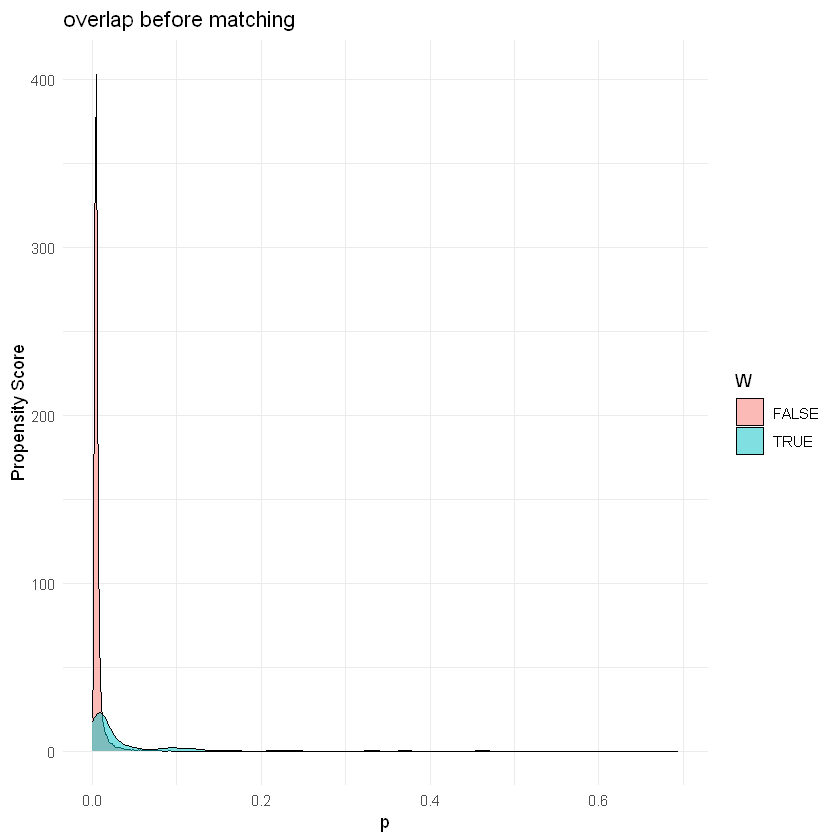

In [15]:
dat_reg_out %>% 
    ggplot(aes(x=p, fill = W)) +
    geom_density(alpha = 0.5) +
    ggtitle("overlap before matching") +
    ylab("Propensity Score") +
    theme_minimal()

### Matching on the estimated propensity score

Nearest neighbor matching, again removing points too close to one another.

In [16]:
# matching
matT <- as.matrix(dat_reg_out %>% filter(W == TRUE) %>% select(s_id, p) %>% arrange(desc(p)))
matC <- as.matrix(dat_reg_out %>% filter(W == FALSE) %>% select(s_id, p) %>% arrange(desc(p)))
match_propscore <- match_v(matT,matC,1,1)
# kick out those that are too close to one another
dSS <- dist_between(as.matrix(dat_cand %>% 
                                filter(s_id %in% match_propscore) 
                              %>% select(s_id, latitude, longitude)),
                    as.matrix(dat_cand %>% 
                                filter(s_id %in% match_propscore) 
                              %>% select(s_id, latitude, longitude)),
                    min(dist_real[dist_real[,1]<dist_real[,2],3]))
dSS <- dSS[dSS[,1]<dSS[,2],]
matC <- as.matrix(dat_reg_out %>% filter(W == FALSE, !(s_id %in% dSS[,1])) %>% select(s_id, p) %>% arrange(desc(p)))
match_propscore <- match_v(matT,matC,1,0)

Finally, inspect overlap after matching

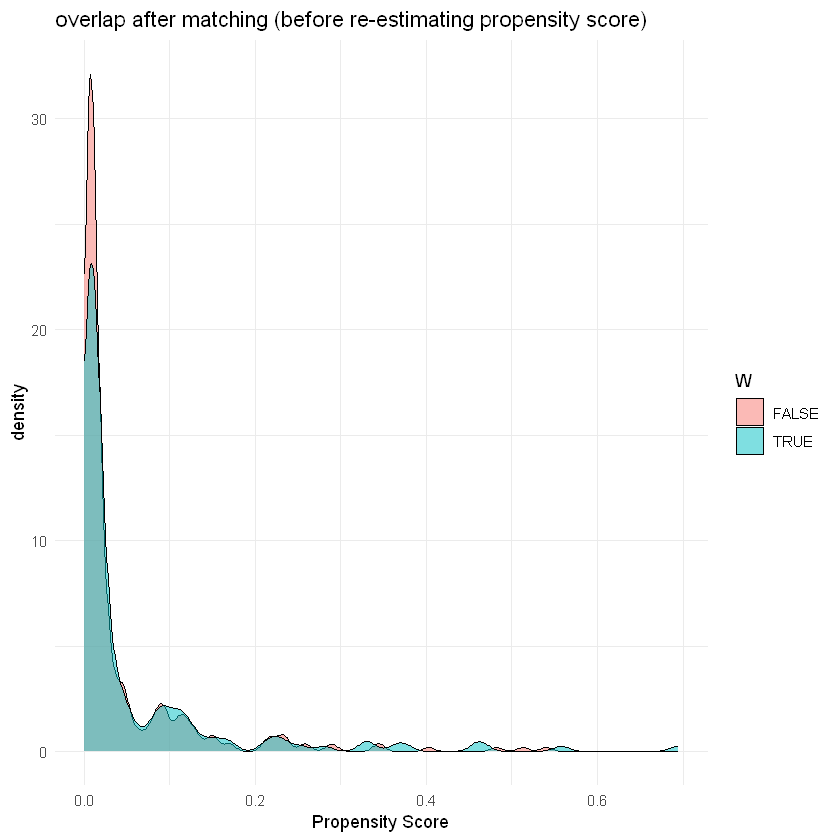

In [17]:
dat_reg_out %>% 
    filter(W == TRUE | s_id %in% match_propscore) %>% 
    ggplot(aes(x=p, fill=W)) +
    geom_density(alpha = 0.5) +
    ggtitle("overlap after matching (before re-estimating propensity score)") +
    xlab("Propensity Score") +
    theme_minimal()

Much better!

Select those matches in the relevant tables:

In [18]:
dat_cand_sel <- dat_reg_out %>% 
    filter(s_id %in% match_propscore) %>% 
    inner_join(dat_cand, by = "s_id") %>% 
    mutate(s_id_old = s_id,
           s_id = 1000 + row_number()) %>% 
    select(s_id, latitude, longitude, s_id_old)
dat_D_cand_sel <- dat_D_all %>% 
    filter(s_id %in% match_propscore) %>% 
    inner_join(dat_cand_sel, by=c("s_id"="s_id_old")) %>% 
    mutate(s_id = s_id.y) %>% 
    select(s_id, a_id, dist_m, dist_km, dist_mi)

dat_reg_p_sel <- dat_reg_p %>% 
    filter(s_id < 1000 | s_id %in% match_propscore) %>% 
    left_join(dat_cand_sel %>% select(s_id, s_id_old), by = c("s_id" = "s_id_old")) %>%
    mutate(s_id = ifelse(is.na(s_id.y),s_id,s_id.y)) %>% 
    select(-s_id.y)

### Re-estimation of the propensity score

Again a logistic regression, this time only on the final sample of selected locations

In [19]:
f <- as.formula(paste("W","~", paste(colnames(dat_reg_p_sel)[-c(1,ncol(dat_reg_p_sel))], collapse = " + ")))
reg_glm_sel <- glm(formula = f, family = "binomial", data = dat_reg_p_sel)
dat_reg_out_sel <- as_tibble(cbind(dat_reg_p_sel %>% select(s_id, W), p = predict(reg_glm_sel, type="response")))

After re-estimating the propensity score, the scores tend to be much larger because estimation was done in the matched sample where the unconditional probability of treatment was noticeably higher than in the sample before matching (which contained many more counterfactual locations).

Mechanically, there is less overlap in the re-estimated propensity score.

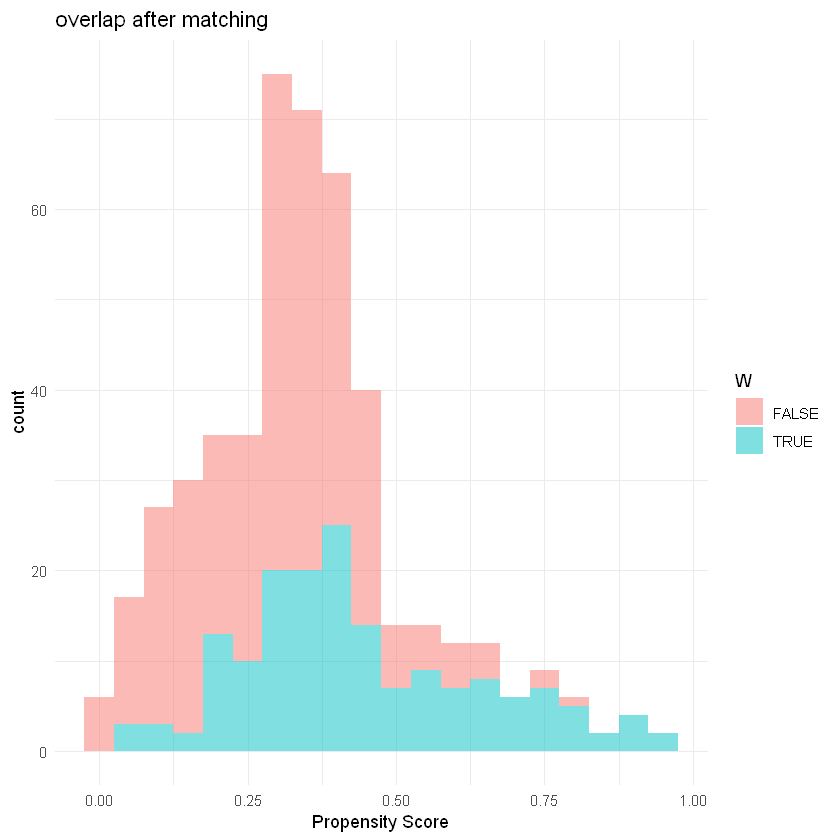

In [20]:
dat_reg_out_sel %>% 
    ggplot(aes(x=p, fill = W)) +
    geom_histogram(alpha = 0.5, binwidth = 0.05) +
    ggtitle("overlap after matching") +
    xlab("Propensity Score") +
    theme_minimal()

But for the most part, the treated and control still resemble one another in terms of propensity scores.
Note that, by definition, at high propensity scores, most units must be treated, and at low propensity scores, most units must be untreated.
We can see that this is indeed the case by plotting whether of the units with propensity score of `p` indeed approximately a fraction `p` is treated:

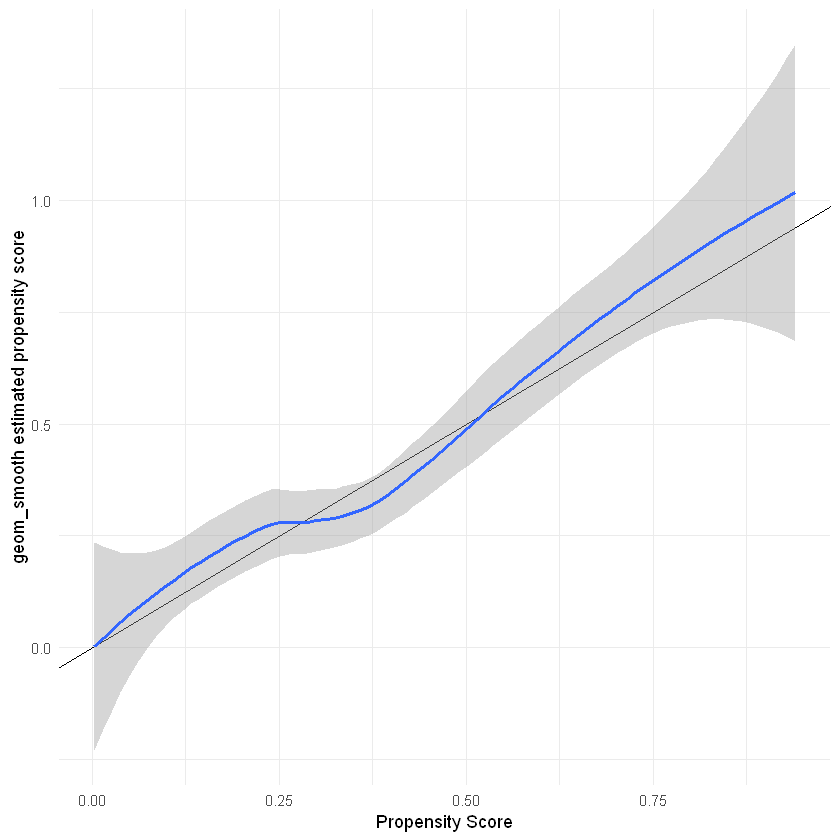

In [21]:
dat_reg_out_sel %>% 
    mutate(W = as.numeric(W)) %>% 
    ggplot(aes(x=p,y=W)) +
    geom_abline(slope=1, intercept=0) +
    geom_smooth(method="loess",formula="y~x") +
    ylab("geom_smooth estimated propensity score") +
    xlab("Propensity Score") +
    theme_minimal()

Note that this should mechanically be the case as long as our logistic regression model was sufficiently flexible.

Finally, save the the chosen counterfactual locations and propensity scores for later use.

In [22]:
saveRDS(dat_cand_sel, "data/dat_cand.rds")
saveRDS(dat_D_cand_sel, "data/dat_D_cand.rds")
saveRDS(dat_reg_p_sel, "data/dat_reg_p_cand.rds")
saveRDS(dat_reg_out_sel, "data/dat_reg_out_sel.rds")
saveRDS(dat_out_num_treat, "data/dat_out_num_treat.rds")

## Visualizing balance in exposure and covariates

Before estimating treatment effects, it is important to check whether the counterfactual locations indeed provide a plausible counterfactual for the treated locations.
Two characteristics are particularly important:

1. Is the exposure to treatment similar but differing by 1 at the distance of interest?
2. Are the areas around the locations similar along other observable characteristics?

Additionally, in a real application, we may plot the real and counterfactual locations on a map to inspect them at a more intuitive level.
If we observe any systematic difference, then the treatment effect estimates may be due to not just difference in exposure to treatment, but also to these other systematic differences.
If there are large differences at this step, me may wish to augment the propensity score matching (using different covariates in propensity score estimation or a different number of matches) or to the neural network (changing for instance the number of layers, the spatial reach of the convolution operation, or the covariates used).

Note that we should carry out these checks before considering any outcome data.

### Exposure to the treatment

Consider the exposure of outcome units to real treatment locations.
Ideally, when estimating the effect on outcome units at distance d, at that distance the units in the treated group have one additional treatment location compared to the control group.
At other distances, the exposure to real treatment locations should be similar.
We can investigate whether this is indeed the case by looking at the difference in average exposure by at different distances for outcome units.

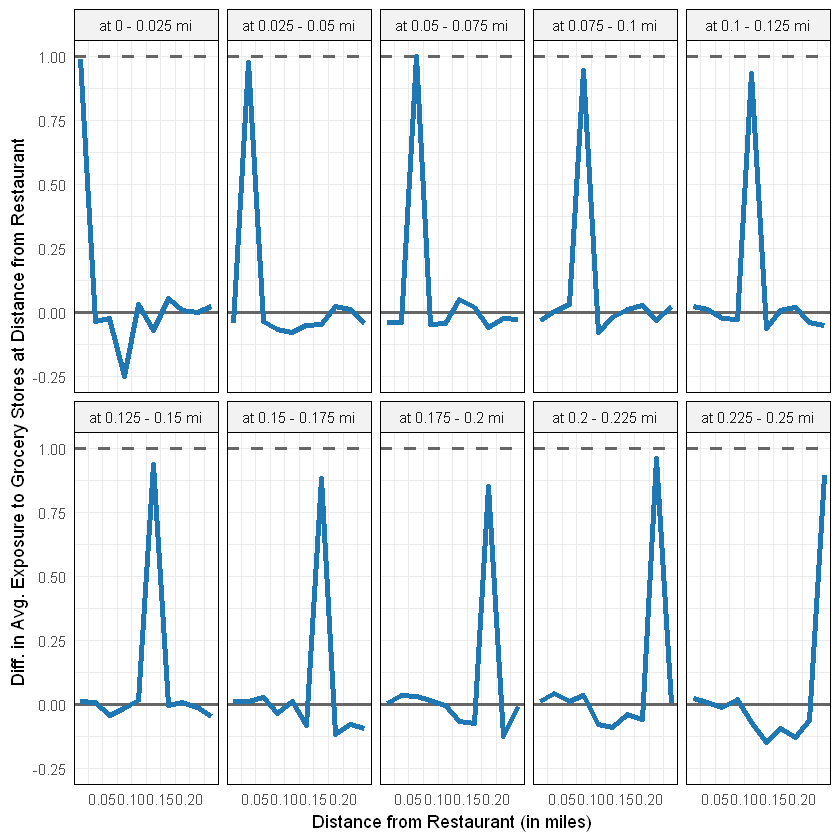

In [23]:
dat_exposure <- rbind(dat_D,dat_D_cand_sel) %>% 
    filter(dist_mi < d_bin_max) %>% 
    inner_join(dat_out_num_treat, by = "a_id") %>% 
    inner_join(dat_reg_out_sel, by = "s_id") %>% 
    mutate(dist_bin = as.integer(floor(dist_mi/d_bin_size))) %>%
    pivot_longer(cols = starts_with("db_a_"),
                 names_to = "dist_from_a",
                 names_prefix = "db_a_",
                 names_transform = list(dist_from_a = as.integer),
                 values_to = "x") %>% 
    group_by(dist_bin, dist_from_a) %>% 
    summarize(x1 = sum(W*x)/sum(W),
              x0 = sum((1-W)/(1-p)*p*x)/sum((1-W)/(1-p)*p),
              n1 = sum(W),
              n0 = sum(1-W),
              .groups = "drop") %>% 
    arrange(dist_bin, dist_from_a)

dat_exposure %>% 
    mutate(diff = x1-x0,
           dist_bin_fact = factor(dist_bin,
                                  levels = sort(unique(dat_exposure$dist_bin)),
                                  labels = paste("at",
                                                 sort(unique(dat_exposure$dist_bin))*d_bin_size,
                                                 "-",
                                                 d_bin_size+sort(unique(dat_exposure$dist_bin))*d_bin_size,
                                                 "mi"))) %>% 
    mutate(d = d_bin_size*dist_from_a + d_bin_size/2,) %>% 
    ggplot(aes(x=d, y=diff)) +
    geom_hline(yintercept = 0, linewidth = 1, color = "#666666") +
    geom_hline(yintercept = 1, linetype = "dashed", linewidth = 1, color = "#666666") +
    geom_line(linewidth = 1.5, color="#1F78B4") +
    facet_wrap(.~ dist_bin_fact, ncol=5) +
    ylab("Diff. in Avg. Exposure to Grocery Stores at Distance from Restaurant") +
    xlab("Distance from Restaurant (in miles)") +
    scale_y_continuous(breaks=seq(-0.25,1,by=0.25)) +
    theme_minimal() +
    theme(legend.position = "none") +
    theme(strip.background = element_rect(fill="#f2f2f2", linetype="solid"),
          panel.border=element_rect(fill=NA))


Looking at outcome units at a certain distance (a particular panel of the figure), we see a spike in the difference in average exposure at exactly the distance at which these outcome units are from the real vs. counterfactual treatment locations.
That is, they are indeed on average exposed to one more treatment location at the correct distance, with exposure at other distances fairly similar between treated and control.
A possible exception are the outcome units that are very close to the locations (top left panel).
For these outcome units, the treated are exposed to slightly fewer real treatments at a distance of about 0.1 miles than the control.
Such differences in exposure should be taken into account when interpreting the effect:
When estimating the effect for the treated and control in the top left panel, we are estimating the effect of on average one more treatment at an extremely short distance and about 0.25 fewer treatments at 0.1 miles.

### Balance in other covariates

We demonstrate that the areas around real and counterfactual treatment locations are similar.
Here, we focus on the types of businesses nearby.
For each treatment location, we count, by distance away, the number of businesses in each industry.

In [24]:
num_ind_by_s_by_dist <- rbind(dat_D,dat_D_cand_sel) %>% 
  filter(dist_mi < 1) %>% 
  inner_join(dat_A, by="a_id") %>% 
  mutate(dist_bin = as.integer(floor(dist_mi/d_bin_size)),
         naics2 = as.integer(floor(naics_code/10000))) %>%
  group_by(s_id, naics2, dist_bin) %>% 
  summarize(n=n(), .groups="drop")
# don't forget about the treatment location-distance-industry tuples without businesses in it
dat_balance <- dat_reg_out_sel %>% 
  left_join(tibble(dist_bin=0:39), by=character()) %>% 
  left_join(tibble(naics2 = sort(unique(floor(dat_A$naics_code/10000)))), by=character()) %>% 
  left_join(num_ind_by_s_by_dist, by = c("s_id", "dist_bin", "naics2")) %>% 
  replace(is.na(.), 0) %>% 
  group_by(s_id,dist_bin) %>% 
  mutate(np = n/max(1,sum(n))) %>% 
  group_by(dist_bin,naics2) %>% 
  summarize(n1 = sum(W*n)/sum(W),
            n0 = sum((1-W)/(1-p)*p*n)/sum((1-W)/(1-p)*p),
            np1 = sum(W*np)/sum(W),
            np0 = sum((1-W)/(1-p)*p*np)/sum((1-W)/(1-p)*p),
            .groups = "drop")

Plot the average number of businesses by industry by distance, for real and counterfactual locations:

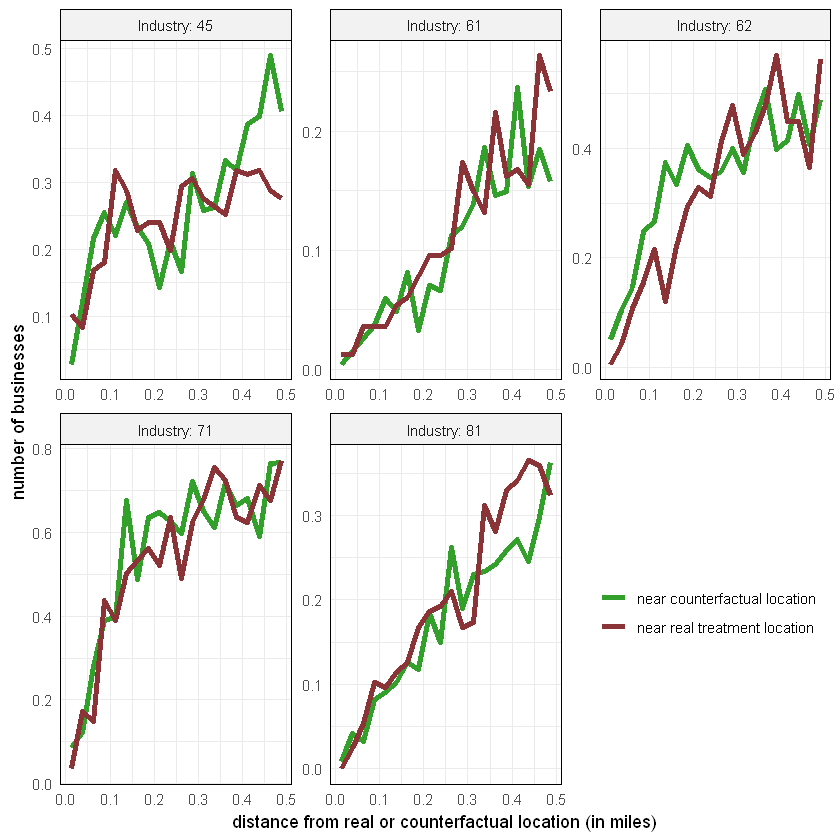

In [25]:

dat_balance %>% 
  filter(dist_bin < 20, !(naics2 %in% c(44,72))) %>% 
  pivot_longer(cols=c("n1","n0"),
               names_prefix = "n",
               names_to = "W",
               names_transform = list(W = as.factor),
               values_to = "x") %>% 
  mutate(naics2_fact = factor(naics2,
                                levels = sort(unique(dat_balance$naics2)),
                                labels = paste("Industry:",
                                               sort(unique(dat_balance$naics2)))),
         d = d_bin_size*dist_bin + d_bin_size/2) %>% 
  ggplot(aes(x=d,y=x,color=W)) +
  geom_line(linewidth=1.5) +
  scale_color_manual(labels = c("near counterfactual location",
                                  "near real treatment location"),
                       values = c("#33A02C", "#8A3437"), name = "") +
  ylab("number of businesses") +
  xlab("distance from real or counterfactual location (in miles)") +
  facet_wrap(.~naics2_fact, scales="free") +
  theme_minimal() +
  theme(legend.position = c(0.85,0.25),
        strip.background = element_rect(fill="#f2f2f2", linetype="solid"),
        panel.border=element_rect(fill=NA))

At least in terms of these coarse summary statistics (corresponding to industries that are neither treatment nor outcome units), the areas around real and counterfactual locations are fairly similar.
Note that this result is not mechanical: 
These variables do not appear directly in the propensity score estimation.
Instead, they are used only in training the neural network.
By focusing analysis on a subset of the locations that appear similar to real locations to the neural network, at least in this case we retain the similarity even after propensity score matching, possibly because the variables used in propensity score estimation are likely somewhat correlated to other spatial characteristics of these areas.

To the extent that there are small differences in these areas, we should interpret treatment effect estimates carefully:
They reflect the combination of difference in exposure (previous figure) and differences in other industry composition (this figure).